## Evaluate performance of `pyctcdecode` on LibriSpeech dev-other

### Prepare the data

In [ ]:
# download librispeech dev-other corpus, using one of the great existing scripts, for example:
#     https://github.com/NVIDIA/NeMo/blob/main/scripts/dataset_processing/get_librispeech_data.py

In [8]:
# load manifest that holds meta information on all files in dev_other
import pandas as pd
dev_other_df = pd.read_json("/my_dir/dev_other.json", lines=True)

### Prepare  transcription logits using a pretrained speech model

### Prepare offical pre-trained language model for librispeech

In [ ]:
# NOTE: some of the code to parse the librispeech data is borrowed from the official NeMo tutorial 
#     https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/Offline_ASR.ipynb

In [ ]:
# download pretrained knelm model for librispeech
import gzip
import os, shutil, wget

lm_gzip_path = '3-gram.pruned.1e-7.arpa.gz'
if not os.path.exists(lm_gzip_path):
    print('Downloading pruned 3-gram model.')
    lm_url = 'http://www.openslr.org/resources/11/3-gram.pruned.1e-7.arpa.gz'
    lm_gzip_path = wget.download(lm_url)
    print('Downloaded the 3-gram language model.')
else:
    print('Pruned .arpa.gz already exists.')

# NOTE: since out nemo vocabulary is all lowercased, we need to convert all librispeech data as well
uppercase_lm_path = '3-gram.pruned.1e-7.arpa'
if not os.path.exists(uppercase_lm_path):
    with gzip.open(lm_gzip_path, 'rb') as f_zipped:
        with open(uppercase_lm_path, 'wb') as f_unzipped:
            shutil.copyfileobj(f_zipped, f_unzipped)
    print('Unzipped the 3-gram language model.')
else:
    print('Unzipped .arpa already exists.')

lm_path = 'lowercase_3-gram.pruned.1e-7.arpa'
if not os.path.exists(lm_path):
    with open(uppercase_lm_path, 'r') as f_upper:
        with open(lm_path, 'w') as f_lower:
            for line in f_upper:
                f_lower.write(line.lower())
print('Converted language model file to lowercase.')

In [12]:
# download unigram vocab
!wget http://www.openslr.org/resources/11/librispeech-vocab.txt

--2021-04-27 12:26:03--  http://www.openslr.org/resources/11/librispeech-vocab.txt
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737588 (1.7M) [text/plain]
Saving to: ‘librispeech-vocab.txt’

librispeech-vocab.t 100%[===================>]   1.66M  1.07MB/s    in 1.6s    

2021-04-27 12:26:05 (1.07 MB/s) - ‘librispeech-vocab.txt’ saved [1737588/1737588]



### Prepare deepspeech decoder

In [ ]:
# !pip install ds_ctcdecoder==0.9.3
# download and unpack native_client.*.tar.xz  from https://github.com/mozilla/DeepSpeech/releases/tag/v0.9.3

# generate a scorer which we can use in the python package
# /my/dir/native_client_0.9.3/generate_scorer_package \
#     --alphabet /my/dir/alphabet.txt \
#     --lm /my/dir/lowercase_3-gram.pruned.1e-7.binary \
#     --vocab /my/dir/lowercase_librispeech-vocab.txt \
#     --package /my/dir/lowercase_3-gram.scorer \
#     --default_alpha 0.5 \
#     --default_beta 1.0

In [ ]:
# prepare logits_list for dev_other like in tutorial tutorials/asr_nemo.ipynb

In [ ]:
import ds_ctcdecoder
from pyctcdecode import build_ctcdecoder

In [ ]:
from scipy.special import softmax

# we need to do array padding for batch decoding
def _pad_array_list(array_list):
    """Pad a list of arrays to have the same length."""
    max_val = max(len(arr) for arr in array_list)
    pad_vec = np.zeros((1, array_list[0].shape[1]))
    pad_vec[0, -1] = 1
    return [np.concatenate([arr] + [pad_vec] * (max_val - arr.shape[0])) for arr in array_list]

In [ ]:
# prepare ds_decoder
ds_alphabet = ds_ctcdecoder.Alphabet("ds_decoder_alphabet.txt")
ds_scorer = ds_ctcdecoder.Scorer(
    0, 0, scorer_path="lowercase_3-gram.scorer", alphabet=ds_alphabet
)
prob_list = [softmax(logits, axis=1) for logits in logits_list]
seq_lengths = [arr.shape[0] for arr in logits_list]
padded_prob_list = _pad_array_list(prob_list)

In [16]:
data_grid = []
for a in [0.6, 0.7, 0.8]:
    for b in [2.0, 3.0, 4.0]:
        decoder.reset_params(alpha=a, beta=b)
        with multiprocessing.get_context("fork").Pool(15) as pool:
            # use lower beam-with here for fast testing
            lm_preds =  decoder.decode_batch(pool, logits_list, beam_width=50)
        wer_val = word_error_rate(dev_other_df["text"].tolist(), lm_preds)
        data_grid.append((a, b, wer_val))
pd.DataFrame(data_grid, columns=["alpha", "beta", "wer"]).sort_values(by="wer").head()

,alpha,beta,wer
4,0.7,3.0,0.076822
0,0.6,2.0,0.076937
1,0.6,3.0,0.077032
3,0.7,2.0,0.077083
7,0.8,3.0,0.077113


### Prepare `pyctcdecode.decoder`

In [6]:
# load unigram list
with open("librispeech-vocab.txt") as f:
    unigram_list = [t.lower() for t in f.read().strip().split("\n")]
    
# load kenlm Model
import kenlm
kenlm_model = kenlm.Model('lowercase_3-gram.pruned.1e-7.arpa')

In [7]:
decoder = build_ctcdecoder(
    asr_model.decoder.vocabulary,
    kenlm_model,
    unigram_list,
)
decoder.decode(logits)

'boil them before they are put into the soup or other dish they may be intended for'

In [10]:
# decode all logits (this may take a while)
logits_list = [
    a.cpu().detach().numpy() 
    for a in asr_model.transcribe(dev_other_df["audio_filepath"].tolist(), logprobs=True)
]

In [11]:
decoder = build_ctcdecoder(
    asr_model.decoder.vocabulary,
    kenlm_model,
    unigram_list,
)

In [12]:
import multiprocessing
with multiprocessing.get_context("fork").Pool() as pool:
    pred_list = decoder.decode_batch(pool, logits_list)

In [13]:
from nemo.collections.asr.metrics.wer import word_error_rate
word_error_rate(dev_other_df["text"].tolist(), pred_list)

0.07708590580349269

In [ ]:
# let's compare this to greedy decoding
def _greedy_decode(logits):
    """Decode argmax of logits and squash in CTC fashion."""
    label_dict = {n: c for n, c in enumerate(labels)}
    prev_c = None
    out = []
    for n in logits.argmax(axis=1):
        c = label_dict.get(n, "")  # if not in labels, then assume it's ctc blank char
        if c != prev_c:
            out.append(c)
        prev_c = c
    return "".join(out)

In [15]:
word_error_rate(dev_other_df["text"].tolist(), [_greedy_decode(l) for l in logits_list])

0.10084215497225611

we did better by using a language model, but we can improve this further by tuning the decoder parameters

In [16]:
data_grid = []
for a in [0.6, 0.7, 0.8]:
    for b in [2.0, 3.0, 4.0]:
        decoder.reset_params(alpha=a, beta=b)
        with multiprocessing.get_context("fork").Pool(15) as pool:
            # use lower beam-with here for fast testing
            lm_preds =  decoder.decode_batch(pool, logits_list, beam_width=50)
        wer_val = word_error_rate(dev_other_df["text"].tolist(), lm_preds)
        data_grid.append((a, b, wer_val))
pd.DataFrame(data_grid, columns=["alpha", "beta", "wer"]).sort_values(by="wer").head()

,alpha,beta,wer
4,0.7,3.0,0.076822
0,0.6,2.0,0.076937
1,0.6,3.0,0.077032
3,0.7,2.0,0.077083
7,0.8,3.0,0.077113


## Compare decoder performance/speed

In [ ]:
# sweep beam_width for custom
data = []
for beam_width in [1, 5, 10, 50, 100, 150, 200]:
    decoder = build_ctcdecoder(
        labels,
        kenlm_model,
        unigrams,
        alpha=0.7,
        beta=3.0,
        score_lm_boundary=True,
    )
    with multiprocessing.get_context("fork").Pool(15) as pool:
        pred_list = decoder.decode_batch(logits_list, pool, beam_width=beam_width)
    wer_val = eval_average_wer(text_list, pred_list)
    t0 = time.time()
    _ = [decoder.decode(l, beam_width=beam_width) for l in logits_list[:500]]
    dur = round((time.time() - t0) / 500 * 1000, 1)
    data.append((wer_val, dur, beam_width, prune_logp))
df_pyctc = pd.DataFrame(data * 100, columns=['wer_val', 'avg_dur_ms', 'beam_width'])

In [ ]:
# sweep beam_width for ds_decoder
data = []
for beam_width in [1, 5, 10, 25, 50, 100, 150, 200]:
    ds_scorer.reset_params(0.7, 2.0)
    out = ds_ctcdecoder.ctc_beam_search_decoder_batch(
        padded_prob_list,
        seq_lengths,
        ds_alphabet,
        beam_width,
        15,
        scorer=ds_scorer,
    )
    pred_list = [e[0][-1] for e in out]
    wer_val = eval_average_wer(text_list, pred_list)
    t0 = time.time()
    _ = [
        ds_ctcdecoder.ctc_beam_search_decoder(
            softmax(l, axis=-1),
            ds_alphabet,
            beam_width,
            scorer=ds_scorer,
        ) 
        for l in logits_list[:500]
    ]
    dur = round(time.time() - t0, 1)
    dur = round((time.time() - t0) / 500 * 1000, 1)
    data.append((wer_val * 100, dur, beam_width))
df_other = pd.DataFrame(data, columns=['wer_val', 'avg_dur_ms', 'beam_width'])

/Users/georg/venvs/kml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/georg/venvs/kml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


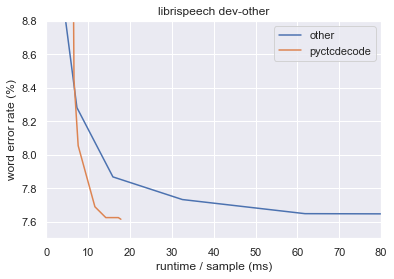

In [50]:
sns.set_theme(style="darkgrid")

x = df_other["avg_dur_ms"].values
y = df_other["wer_val"].values
sns.lineplot(x, y, label="other")

x = df_pyctc["avg_dur_ms"].values
y = df_pyctc["wer_val"].values
sns.lineplot(x, y, label="pyctcdecode")

plt.xlabel('runtime / sample (ms)')
plt.ylabel("word error rate (%)")
plt.title("librispeech dev-other")
plt.axis([0, 80, 7.5, 8.8])
plt.show()